In [ ]:
import torch 
from torch.utils.data import DataLoader
from transformers import AutoTokenizer,AutoModelForSequenceClassification, DistilBertForSequenceClassification
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from fine_tune import model_performance,ConversationDataset,distill_bert_models

In [19]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")


In [20]:
device= torch.device('cpu')

In [21]:
teacher_model = AutoModelForSequenceClassification.from_pretrained("/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/llm_fine/LLM_fine_Tune",num_labels=6 ).to(device)

In [25]:
df = pd.read_parquet("/Users/ritkumar17/Desktop/R&D_Project/LLM_fine/llm_fine/clean_dataset.parquet")

In [26]:
# Encode Labels
labels = df["issue_area"].unique().tolist()
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()} # BERT treats labels as distinct categories, not numbers.
df["label"] = df["issue_area"].map(label2id)

In [27]:
df.head()

,conversation,label,issue_area
0,Thank you for calling BrownBox Customer Suppor...,0,Login and Account
1,Thank you for calling BrownBox customer suppor...,1,Cancellations and returns
2,Thank you for calling BrownBox Customer Suppor...,1,Cancellations and returns
3,"Hi, I am facing an issue while logging into my...",0,Login and Account
4,Thank you for contacting BrownBox customer sup...,2,Order


In [ ]:


student_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=6 )
student_model_toeknizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

train_x, test_x, train_y, test_y = train_test_split(df["conversation"], df["label"], test_size=.2, random_state=22,stratify=df["label"])
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=.1, random_state=22,stratify=train_y)


slm_train_dataset = ConversationDataset(train_x, train_y, student_model_toeknizer )
slm_test_dataset = ConversationDataset(test_x, test_y, student_model_toeknizer)
slm_val_dataset = ConversationDataset(val_x, val_y, student_model_toeknizer)

slm_train_loader = DataLoader(slm_train_dataset, batch_size=16, shuffle=True)
slm_test_loader = DataLoader(slm_test_dataset, batch_size=16, shuffle=False)
slm_val_loader = DataLoader(slm_val_dataset, batch_size=16, shuffle=False)

# Get all training labels
train_labels = [batch['labels'].numpy() for batch in slm_train_loader]
train_labels = np.concatenate(train_labels)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 2.9050, Train F1: 0.2171, Val Loss: 1.5812, Val F1: 0.3444
Model checkpoint saved.
Epoch 2, Train Loss: 1.9307, Train F1: 0.6036, Val Loss: 0.8141, Val F1: 0.7890
Model checkpoint saved.
Epoch 3, Train Loss: 1.0897, Train F1: 0.8303, Val Loss: 0.3669, Val F1: 0.8981
Model checkpoint saved.
Epoch 4, Train Loss: 0.6318, Train F1: 0.9243, Val Loss: 0.2363, Val F1: 0.9364
Model checkpoint saved.
Epoch 5, Train Loss: 0.4047, Train F1: 0.9525, Val Loss: 0.1875, Val F1: 0.9119
No improvement. Patience: 1/2
Epoch 6, Train Loss: 0.2892, Train F1: 0.9775, Val Loss: 0.1652, Val F1: 0.9249
No improvement. Patience: 2/2
Early stopping triggered.


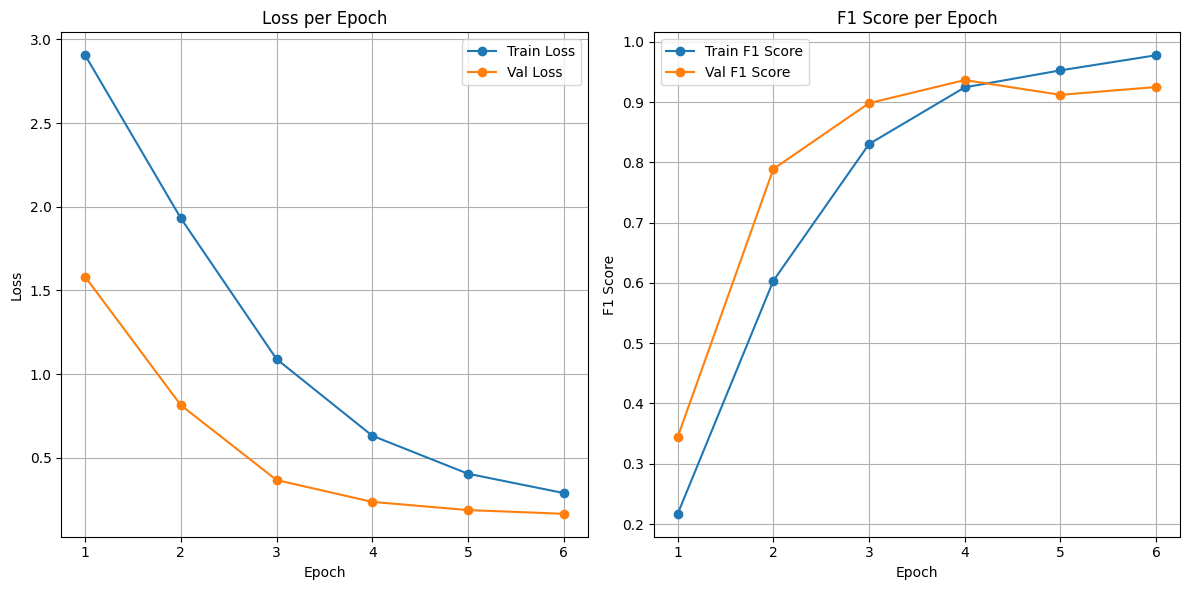

In [ ]:

distilled_model = distill_bert_models(
    student=student_model,
    teacher=teacher_model,
    train_loader=slm_train_loader,
    eval_loader=slm_val_loader,
    num_classes=6,
    train_labels=train_labels,
    num_epochs=10,
    lr=3e-5,
    alpha=0.6,
    temp=2.0,
    hidden_weight=0.7,
    attn_weight=0.3
)

In [34]:
logit=model_performance(distilled_model, slm_test_loader, device, id2label)

 Model Accuracy : 0.9350

Overall F1-score (Weighted): 0.9346
                           precision    recall  f1-score   support

        Login and Account       1.00      1.00      1.00        30
Cancellations and returns       0.93      0.96      0.95        57
                    Order       0.90      0.85      0.88        54
                 Shopping       0.91      0.91      0.91        23
                 Warranty       1.00      1.00      1.00        21
                 Shipping       0.88      0.93      0.90        15

                 accuracy                           0.94       200
                macro avg       0.94      0.94      0.94       200
             weighted avg       0.93      0.94      0.93       200

